## Mask R-CNN - Inspect Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.
Please make sure the right function was used.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model_final as modellib # The final version of Backbone network (ResNet 18 only)
# import mrcnn.model_new as modellib # For the rest of Backbone network (ResNet 101, 50, 34)
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

## Configurations

In [2]:
import coco_RBP
config = coco_RBP.CocoConfig()
COCO_DIR = r"E:\GitHub\data"  # TODO: enter value here

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MAX_DIM = 1024
    MAGE_MIN_DIM = 800
    DETECTION_MIN_CONFIDENCE = 0.7
    NUM_CLASSES = 1 + 5
    BACKBONE = "resnet18"
    USE_MINI_MASK = False
    # RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    # FPN_CLASSIF_FC_LAYERS_SIZE = 768

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet34
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         True
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MAGE_MIN_DIM                   800
MASK_POOL_SIZE     

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
dataset = coco_RBP.CocoDataset()
dataset.load_coco(COCO_DIR, "test_coco")

dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Image Count: 60
Class Count: 6
  0. BG                                                
  1. pilers                                            
  2. screwdriver                                       
  3. wheel                                             
  4. holder                                            
  5. cylinder                                          
Images: 60
Classes: ['BG', 'pilers', 'screwdriver', 'wheel', 'holder', 'cylinder']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
    # weights_path = model.find_last()
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
Loading weights  e:\GitHub\mask_rcnn_coco.h5


In [8]:
model.load_weights(r"E:\GitHub\weighting\ResNet34\mask_rcnn_coco_0050.h5", by_name=True)

In [9]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

## Run Detection

In [10]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: coco.37 (36) http://cocodataset.org/#explore?id=37


image ID: coco.5 (4) http://cocodataset.org/#explore?id=5
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


c:\Users\user\anaconda3\envs\tf_2.5\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  297.00000  max:  742.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


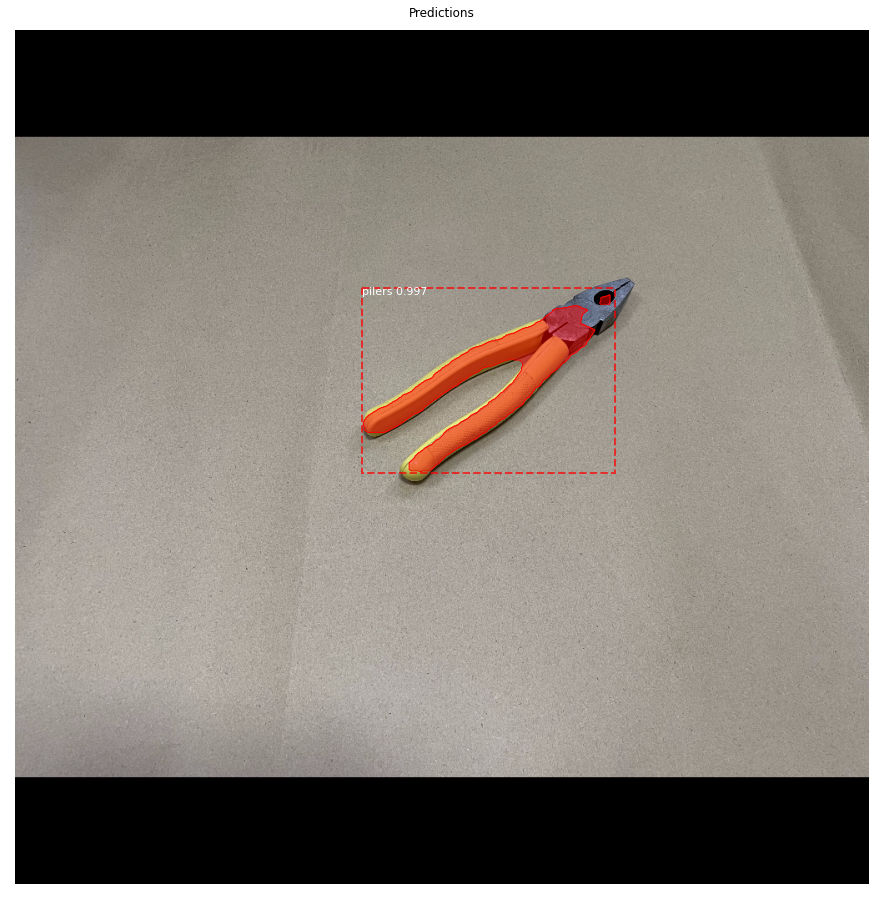

In [11]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [12]:
model.mold_inputs([image])[0][0].shape

(1024, 1024, 3)

### Precision-Recall

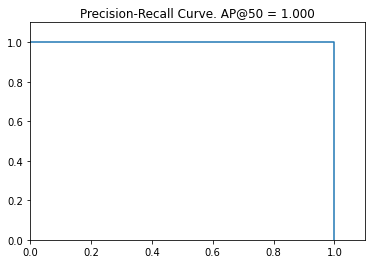

In [13]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

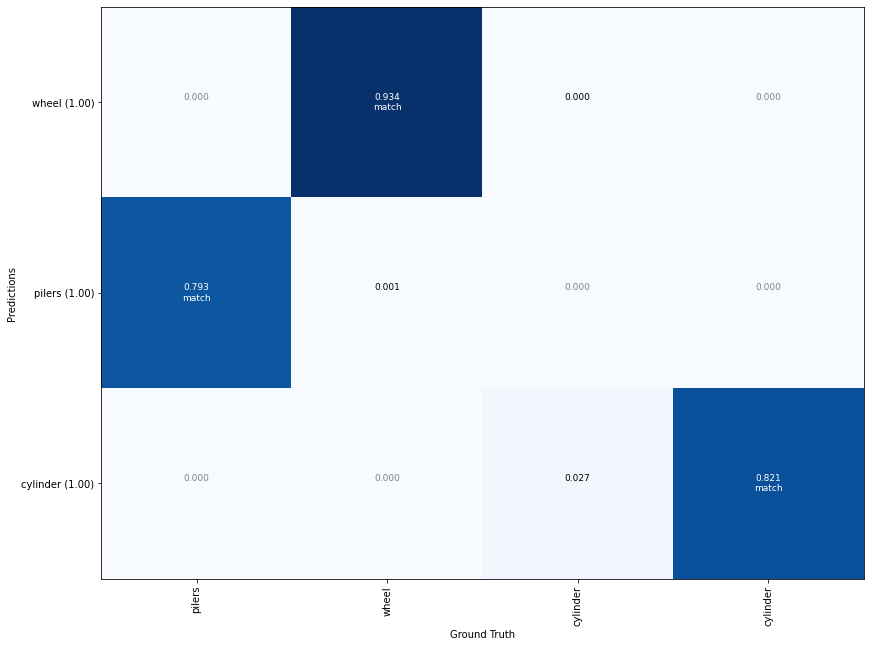

In [14]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [13]:
image_ids = np.random.choice(dataset.image_ids, 50)

In [15]:
image_ids

array([ 6, 39, 23, 13, 35, 53, 23, 16,  0,  9, 56, 26, 45, 11, 37, 46, 37,
       38,  8,  1, 28, 29, 42, 20, 44,  5, 13, 19, 39, 30, 23,  7, 37, 57,
       18, 49, 11, 11, 14,  1, 53, 57, 55, 59, 15, 48, 47, 20, 12, 58])

In [14]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids, iou_threshold):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=iou_threshold)
        APs.append(AP)
    return APs

# Pick a set of random images
# image_ids = np.random.choice(dataset.image_ids, 50)
APs = compute_batch_ap([1,2,3], iou_threshold=0.5)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  1.0


In [18]:
# image_ids = np.random.choice(dataset.image_ids, 100)
APs = compute_batch_ap(image_ids, iou_threshold=0.75)
print("mAP @ IoU=75: ", np.mean(APs))

mAP @ IoU=75:  0.6676111131409803


In [40]:
def compute_batch_IoU(image_ids):
    IoUs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        overlaps = utils.compute_overlaps(gt_bbox, r['rois'])
        overlaps = np.mean(np.max(overlaps, axis=1))

        IoUs.append(overlaps)
    return IoUs

In [41]:
IoUs = compute_batch_IoU(image_ids)
np.mean(IoUs)

0.8372958835033814

## Weighting Save

In [12]:
from tensorflow.keras.models import Model

input = model.keras_model.inputs[0]

C1 = model.keras_model.get_layer("max_pooling2d").output
C2 = model.keras_model.get_layer("res2c_out").output
C3 = model.keras_model.get_layer("res3d_out").output
C4 = model.keras_model.get_layer("res4w_out").output
C5 = model.keras_model.get_layer("res5c_out").output

In [16]:
tutorial_model = Model(input,[C2,C3,C4,C5])

In [13]:
P2 = model.keras_model.get_layer("fpn_p2").output
P3 = model.keras_model.get_layer("fpn_p3").output
P4 = model.keras_model.get_layer("fpn_p4").output
P5 = model.keras_model.get_layer("fpn_p5").output
P6 = model.keras_model.get_layer("fpn_p6").output

In [14]:
tutorial_model = Model(input,[P2,P3,P4,P5,P6])

In [11]:
rpn = model.keras_model.get_layer("rpn_class").output

In [12]:
tutorial_model = Model(input,rpn)

In [18]:
tutorial_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
______________________________________________________________________________________________

In [15]:
tutorial_model.save(r"E:\weighting\coco2017\ResNet101\tutorial_P.h5")

c:\Users\user\anaconda3\envs\tf_2.5\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Predicted Masks

In [43]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    5.00000  float32
masks                    shape: (1, 100, 28, 28, 6)   min:    0.00000  max:    0.99998  float32
6 detections: ['cylinder' 'pilers' 'wheel' 'wheel' 'holder' 'pilers']


In [44]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (6, 28, 28)           min:    0.00000  max:    0.99989  float32
det_masks                shape: (6, 1024, 1024)       min:    0.00000  max:    1.00000  bool


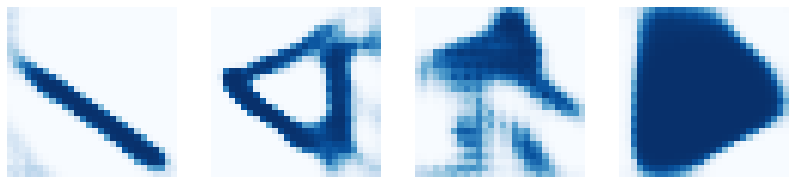

In [45]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

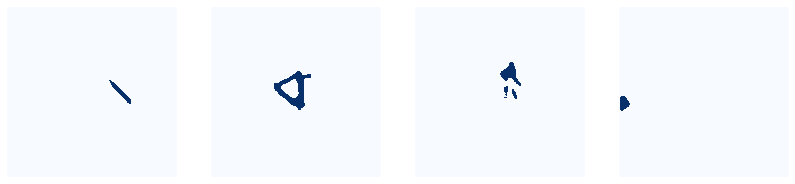

In [46]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [34]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   54.64681
rpn_bbox                 shape: (1, 65472, 4)         min:  -12.26412  max:   18.18265
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


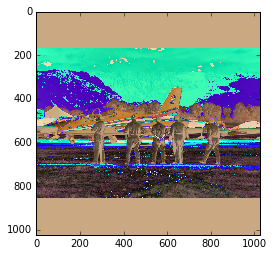

In [35]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

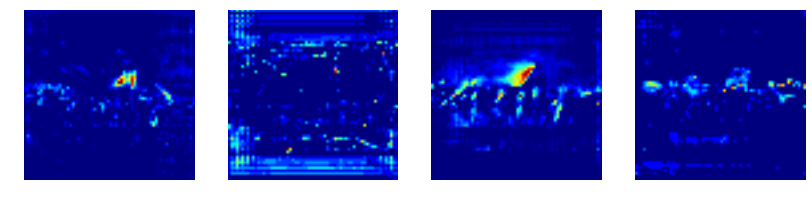

In [36]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

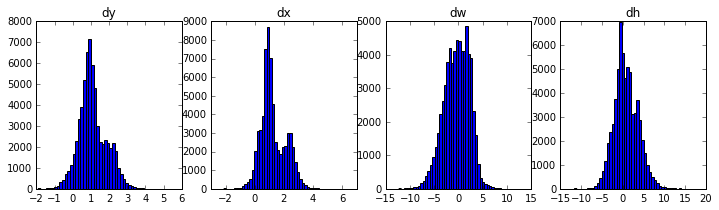

In [37]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

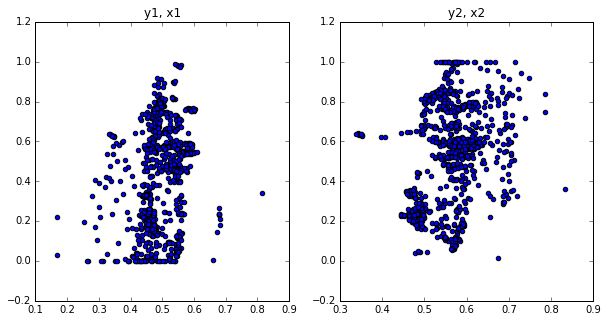

In [38]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()